In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\L42G\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\L42G\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
rpath = os.path.abspath(r'C:\\Users\\L42G\\Documents\\GitHub\\week0_starter_network_analysis')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [8]:
def slack_parser(path_channel):
    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            file_content = json.load(slack_data)
            combined.append(file_content)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
                     msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
    dfall = dfall.reset_index(drop=True)
    
    return dfall

In [39]:
df1 = slack_parser(r'C:/Users/L42G/Documents/GitHub/week0_starter_network_analysis/data/TopicModelingData/')
df1.head(2)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,Good morning everyone :blush: welcome to week ...,Garrett Bell,1665385707.569729,text,0,0,0,0,0,
1,message,Good morning!,Carlos Gross,1665385734.616309,text,0,0,0,0,0,


In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           189 non-null    object
 1   msg_content        189 non-null    object
 2   sender_name        189 non-null    object
 3   msg_sent_time      189 non-null    object
 4   msg_dist_type      189 non-null    object
 5   time_thread_start  189 non-null    object
 6   reply_count        189 non-null    int64 
 7   reply_users_count  189 non-null    int64 
 8   reply_users        189 non-null    object
 9   tm_thread_end      189 non-null    object
 10  channel            189 non-null    object
dtypes: int64(2), object(9)
memory usage: 16.4+ KB


Text(0.5, 1.0, 'Cardinality')

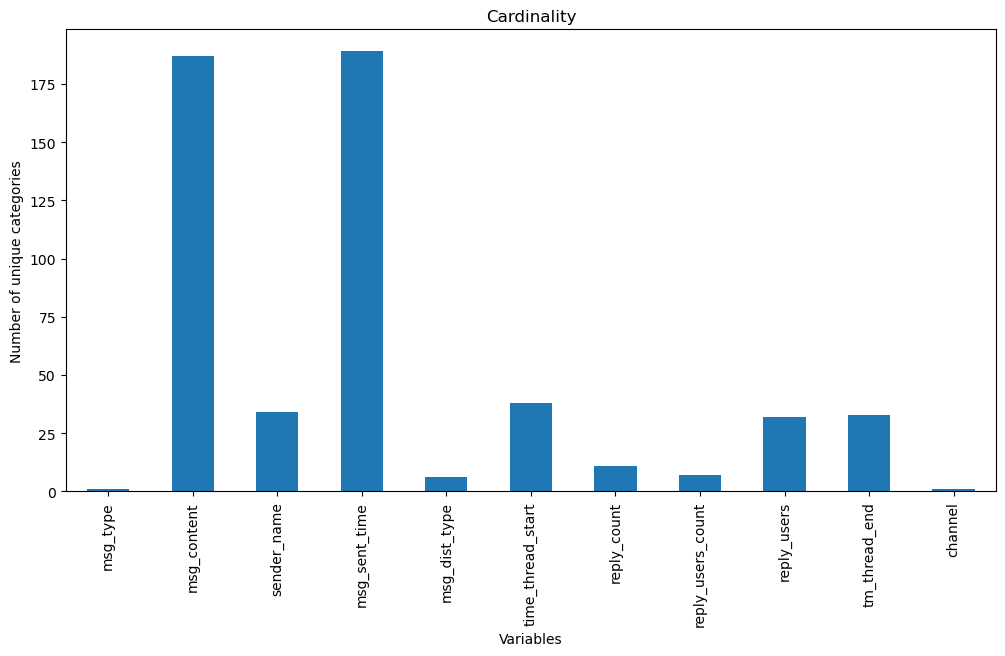

In [41]:
df1.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

In [42]:
class PrepareData:
  def __init__(self,df):
    self.df=df

  def preprocess_data(self):
    df1 = self.df.loc[self.df['lang'] =="en"]


    #text Preprocessing
    df1['msg_content']=df1['msg_content'].astype(str)
    df1['msg_content'] = df1['msg_content'].apply(lambda x: x.lower())
    df1['msg_content']= df1['msg_content'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

    #Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in df1['msg_content']]
    word_list = [sent.split() for sent in sentence_list]
    # print(word_list)

    #Create dictionary which contains Id and word
    word_to_id = corpora.Dictionary(word_list) #generate unique tokens
    #  we can see the word to unique integer mapping
    # print(word_to_id.token2id)
    # using bag of words(bow), we create a corpus that contains the word id and its frequency in each document.
    corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]
    # TFIDF

    return df1,word_list, word_to_id, corpus_1


In [ ]:
PrepareData_obj=PrepareData(df1)
df,word_list ,id2word,corpus=PrepareData_obj.preprocess_data()

In [45]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           189 non-null    object
 1   msg_content        189 non-null    object
 2   sender_name        189 non-null    object
 3   msg_sent_time      189 non-null    object
 4   msg_dist_type      189 non-null    object
 5   time_thread_start  189 non-null    object
 6   reply_count        189 non-null    int64 
 7   reply_users_count  189 non-null    int64 
 8   reply_users        189 non-null    object
 9   tm_thread_end      189 non-null    object
 10  channel            189 non-null    object
dtypes: int64(2), object(9)
memory usage: 16.4+ KB


In [47]:
# Remove the columns
df1 = df1.drop(columns=['msg_sent_time', 'msg_dist_type', 'time_thread_start','reply_count','reply_users','tm_thread_end','channel'])
# Print out the first rows of papers
df1.head()

KeyError: "['msg_sent_time', 'msg_dist_type', 'time_thread_start', 'reply_count', 'reply_users', 'tm_thread_end', 'channel'] not found in axis"